# Прогнозирование оттока клиентов в телекомуникационной компании

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
   
Описание услуг
    
Оператор предоставляет два основных типа услуг: 
  1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
  2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
    
Также доступны такие услуги:
  1. Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
  2. Выделенная линия технической поддержки (TechSupport);
  3. Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
  4. Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
  
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

   Цель проекта: научиться прогнозировать уход клиента

План проекта:
1. Загрузка данных, ознакомление с данными
- describe(), info()
2. Объединение датасетов
- выделение целевого признака
3. Предобработка данных
- заполнение пропусков
- выделение новых признаков
- проверка на мультиколлинеарность
- удаление ненужных признаков
4. Разделение на выборки
- кодирование категориальных признаков
5. Обучение моделей и проверка лучшей
- Подбор гиперпараметров и обучение на кросс-валидации логистической регрессии, случайного леса, модели градиентного бустинга
- выбор лучшей
- проверка на тестовой выборке
6.  Выводы
- анализ важности признаков
- матрица ошибок.


# Загрузка и изучение данных.

In [1]:
#!pip install -U scikit-learn

In [2]:
!pip install phik
!pip install skimpy

In [3]:
import pandas as pd
import numpy as np
import phik
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimpy import clean_columns
import warnings
warnings.filterwarnings("ignore")   
import catboost as cb

In [4]:
link_contract = 'https://code.s3.yandex.net/datasets/contract_new.csv'
contract = pd.read_csv(link_contract,  sep=',')
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
link_personal = 'https://code.s3.yandex.net/datasets/personal_new.csv'
personal = pd.read_csv(link_personal,  sep=',')
personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
link_internet = 'https://code.s3.yandex.net/datasets/internet_new.csv'
internet = pd.read_csv(link_internet,  sep=',')
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [7]:
link_phone = 'https://code.s3.yandex.net/datasets/phone_new.csv'
phone = pd.read_csv(link_phone,  sep=',')
phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [8]:
def observe(data):
    print('Информация о датасете:', data.info())
    print('Явные дубликаты:', data.duplicated().sum())   
    print('Статистика:', data.describe()) 
    return
observe(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
Информация о датасете: None
Явные дубликаты: 0
Статистика:        MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000


In [9]:
observe(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
Информация о датасете: None
Явные дубликаты: 0
Статистика:        SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


In [10]:
observe(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
Информация о датасете: None
Явные дубликаты: 0
Статистика:         customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

  

In [11]:
observe(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
Информация о датасете: None
Явные дубликаты: 0
Статистика:         customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390


Мы ознакомились с 4мя датасетами. Не обнаружили пропусков в каждом из датасетов, не обнаружили дубликатов и каких-то аномалий в данных. В некоторых признаках определен 
неверно тип данных, например в таблице contract  в столбцах BeginDate, EndDate,TotalCharges  - изменим тип далее.


## Объединение датасетов

Объединим датасаты в один датафрейм по столбцу с уникльными значениями customerID.

In [12]:
df = contract \
    .merge(personal, how='left', on='customerID') \
    .merge(internet, how='left', on='customerID') \
    .merge(phone, how='left', on='customerID') 
# назначим customerID индексами
df = df.set_index('customerID')
#оформим названия колонок по правилам
df = clean_columns(df)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv  

После объединения таблицы видим, что количество строк соответствует количеству контрактов. 1526 пропусков в признаках получилось из таблицы с доп услугами интернета, это означает, что 1526 клиентов не проводили себе интернет и пользуются только телефонией. 682 пропуска в признаке из таблицы  с доп услугой связи, это означает, что  682 клиента не подключали телефон и пользуются только интерентом.

### Выделим целевой признак.

Так как цель работы спрогнозировать уход клиента для выделения целевого признака воспользуемся колонкой с датой окончания контракта EndDate(если в столбце проставлена дата-значит пользователь ушел, если стоит значение 'No' - клиент продолжает пользоваться услугами).Создадим новый столбец, в котором  будут значения 0 - не ушел, 1 - ушел. 

In [14]:
df['activity'] =(df['end_date'] != 'No').astype(int)
df.head(5)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,activity
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


In [15]:
# Переведем числовые данные в верный формат и найдем продолжительность пользования услугами в днях для каждого клиента
# Так как дата выгрузки 01-02-2020 заменим 'No' в столбце EndDate этой датой
df['end_date'] = pd.to_datetime(df['end_date'].replace(['No'], ['2020-02-01']), format='%Y-%m-%d')
df['begin_date'] =  pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df['duration'] = (df['end_date'] - df['begin_date']).dt.days
# заменим тип данных в столбце TotalCharges
#df['TotalCharges'] = df['TotalCharges'].astype(float)
df['total_charges'] = pd.to_numeric(df['total_charges'], errors ='coerce')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

Таблицы объединили, новые столбцы создали, изменили типы данных, где было необходимо. Однако появились пропуски, тк клиенты не обязательно пользуются всеми услугами компании. Заменим их на новые значения 'not_used' для пропусков в услугах InternetService и MultipleLines - так выделим пользователей, которые не пользуются интернетом или услугами связи вобще,  и 'No' заменим пропуски в доп услугах интернета. Также мы видим пропуски в TotalCharges, где их не было. Далее расмотрим поближе.


In [17]:
# Рассмотрим пропуски в TotalCharges
df[df['total_charges'].isnull()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,activity,duration
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0


Всего 11 строк с NaN. По дате начала контракта видим, что пользователи стали клиентами компании в день выгрузки, поэтому вместо пропусков ставим 0, тк им еще не начислено ни одного платежа.

In [18]:
# заменяем пропуски связанные с неиспользованием интернета или телефона.
df['internet_service'] = df['internet_service'].fillna('not_used')
for column in('online_security','online_backup', 'device_protection', 'tech_support', 'streaming_tv','streaming_movies'):
    df[column] = df[column].fillna('No')
df['multiple_lines'] = df['multiple_lines'].fillna('not_used')


In [19]:
# Заменяем пропуски в платежах
df['total_charges'] = df['total_charges'].fillna(0)


Так как решается задача классификации и мы вывели новые признаки на основе дат, можно столбцы с датами удалить.

In [20]:
df = df.drop(['end_date', 'begin_date'], axis = 1) 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines

Теперь рассмотрим корреляцию признаков, проверим признаки на мультиколлинеарность.

In [22]:
cor = df.phik_matrix(['monthly_charges', 'total_charges', 'duration']).round(2)

<AxesSubplot:>

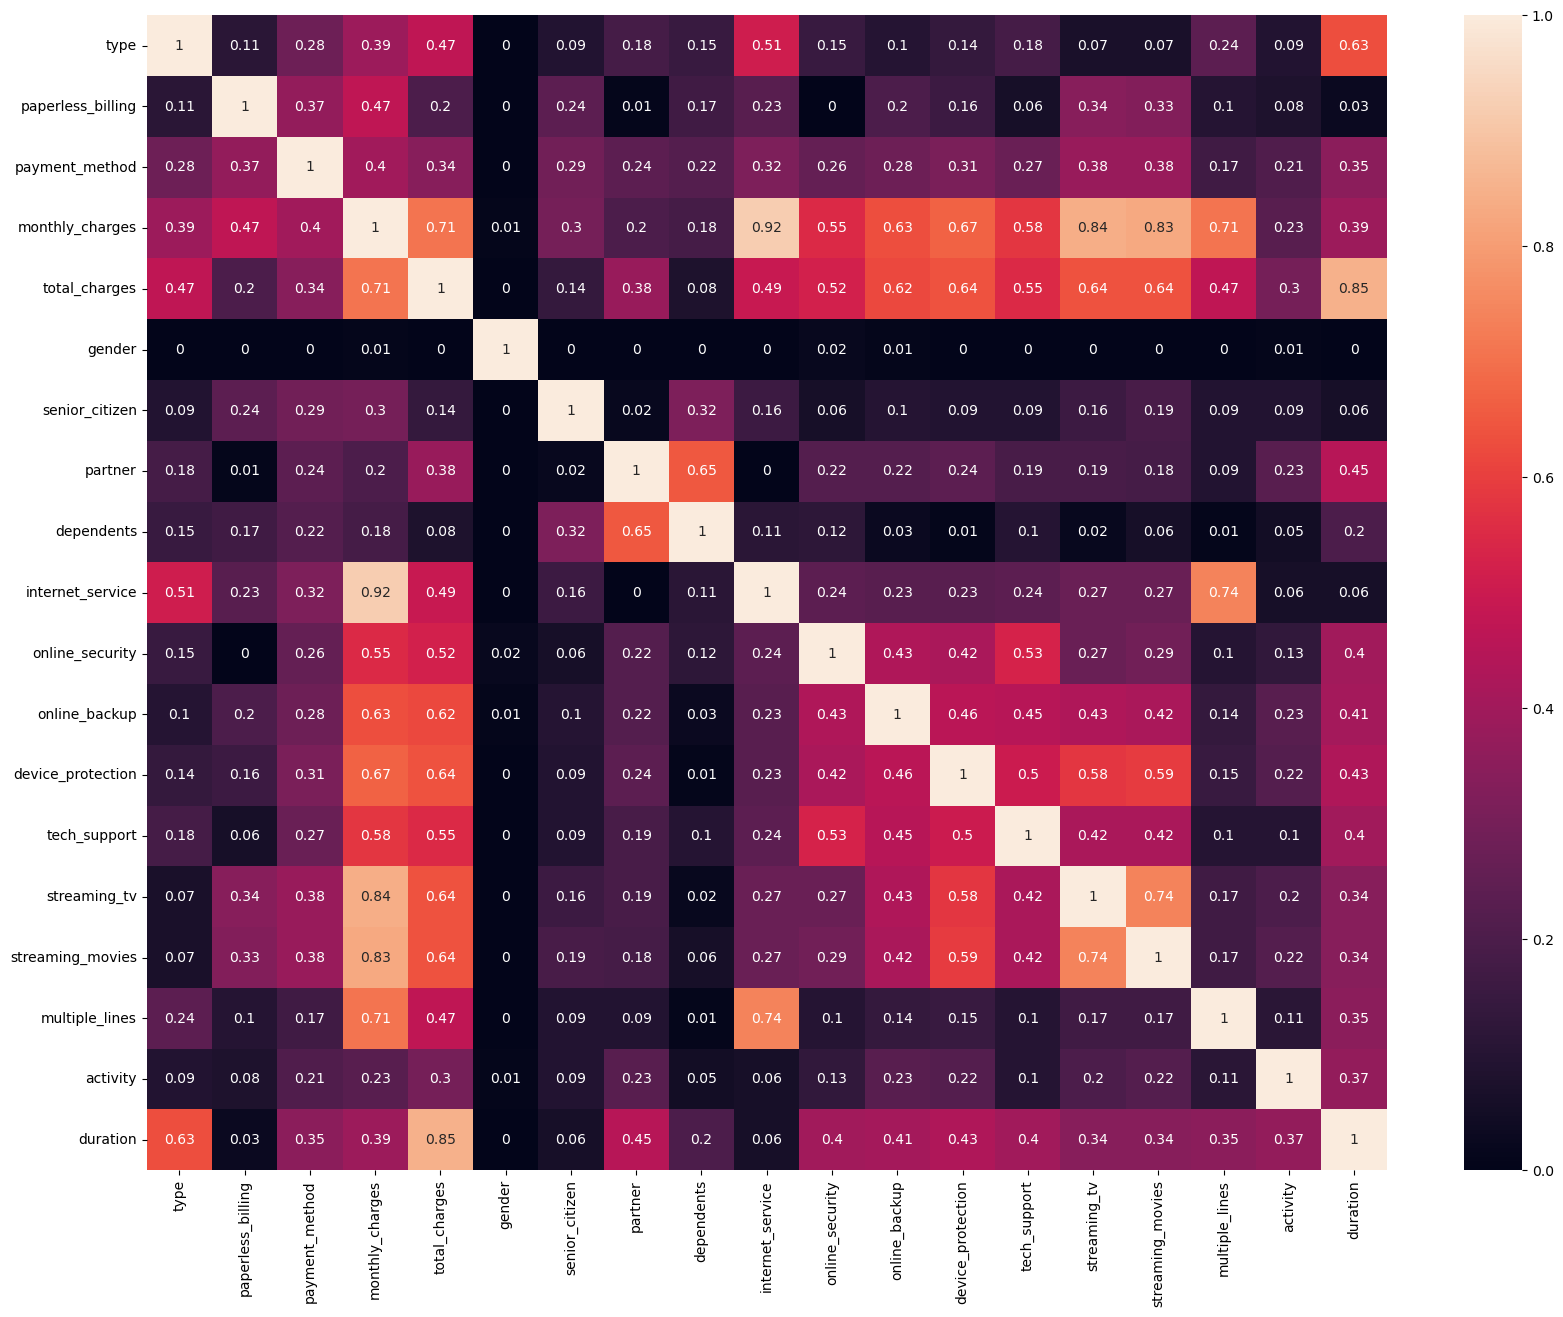

In [23]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(cor, annot = True)

По матрице корреляции мы видим, что есть мультиколлинеарность признаков, а именно значение TotalCharges связано с длительностью пользования услугами компании. Удалим признак TotalCharges.

In [24]:
df = df.drop(['total_charges'], axis = 1)

Также видим высокую корреляцию MonthlyCharges с признаками InternetService, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, MultipleLines. Построим графики и примем решение относительно удаления признаков для моделирования.

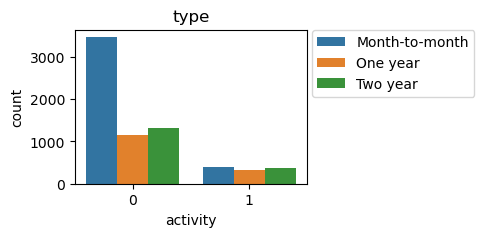

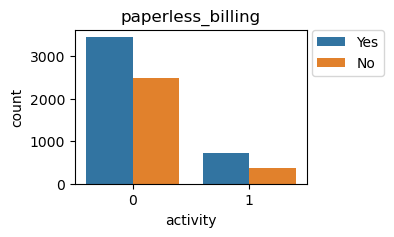

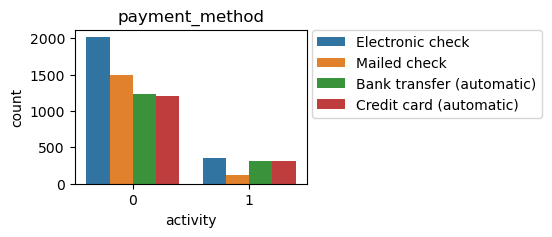

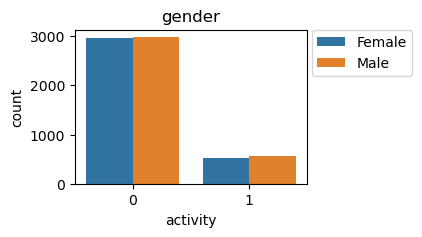

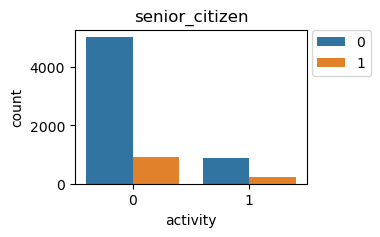

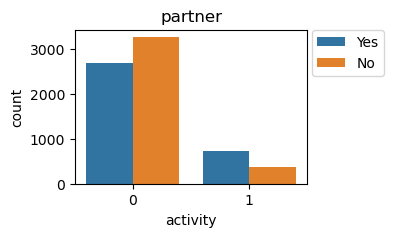

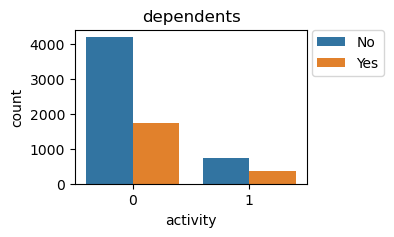

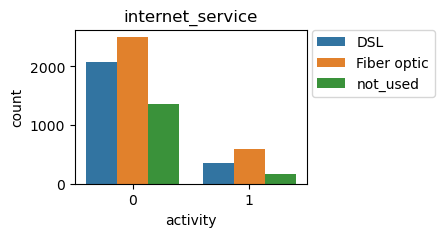

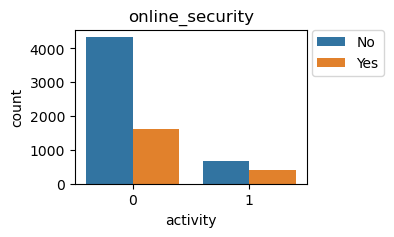

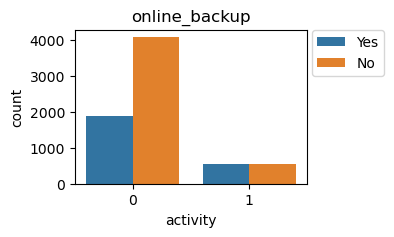

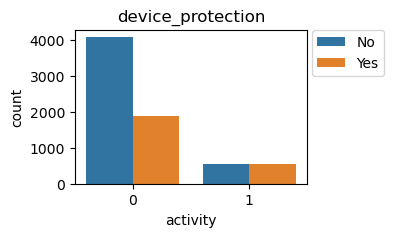

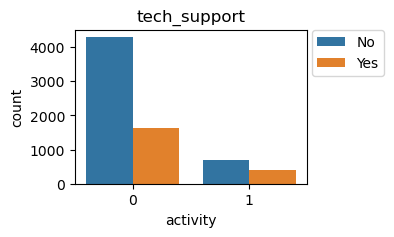

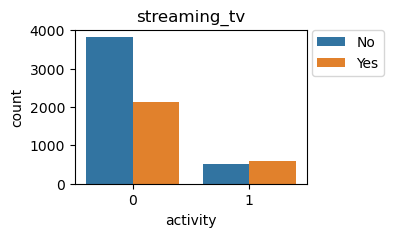

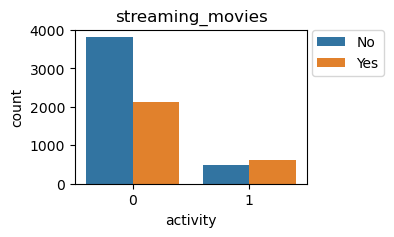

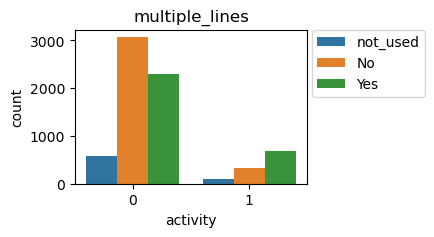

In [25]:
for column in('type', 
              'paperless_billing', 
              'payment_method',
              'gender', 
              'senior_citizen',
              'partner', 
              'dependents', 
              'internet_service', 
              'online_security',
              'online_backup',
              'device_protection', 
              'tech_support', 
              'streaming_tv',
              'streaming_movies', 
              'multiple_lines'):
    plt.figure(figsize = (3,2))
    sns.countplot(data = df, x = 'activity', hue=column).set_title(column)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad= 0)

In [ ]:
for column in('type', 
              'paperless_billing', 
              'payment_method',
              'gender', 
              'senior_citizen',
              'partner', 
              'dependents', 
              'internet_service', 
              'online_security',
              'online_backup',
              'device_protection', 
              'tech_support', 
              'streaming_tv',
              'streaming_movies', 
              'multiple_lines'):
    plt.figure(figsize = (3,2))
    sns.countplot(data = df, x = 'activity', hue=column).set_title(column)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad= 0)

1. По графикам видим, что признаки gender и dependents распределяются приблизительно в одинаковых пропорциях в группах по целевому признаку, также корреляция  этих признаков с целевым 0,01 и 0,05 соответственно. Оба этих фактора говорят нам в пользу исключения признаков из выборки.
2. По признаку тип оплаты видим, что большинство действующих клиентов предпочитают помесячный способ оплаты, ушедшие же платили разными способами примерно в равных долях. Большая часть ушедших пользовалась бумажными счетами. Предпочтительным способом оплаты для действующих договоров является онлайн платеж, для ушедших онлайн платеж и автоплатежи. Люди не достигшие пенсионного возраст чаще разрывают договор, чем достигшие. Пользователи не имеющие партнера более лояльны. Пользователи оптоволкна уходят чаще. Уходят клиенты с услугой online backup и без нее примерно одинаково, однако среди действующих большее количество предпочитают не подключать.Та же картина с услугой device protection. Среди лояльных клиентов часть не имеет тех.поддержки и примерно в 2,5 раза меньше имеют, у ушедших соотношение ближе к 2:1. Услуги streaming_tv  и streaming_movies имелись у больей части ушедших клиентов. Наличие нескольких линий у большего количества ушедших.
3. По графикам видим дисбаланс классов. 

In [26]:
df = df.drop(['gender', 'dependents'], axis = 1)


Построим графики для оценки продолжительности договоров.

Text(0.5, 0, 'Количество дней')

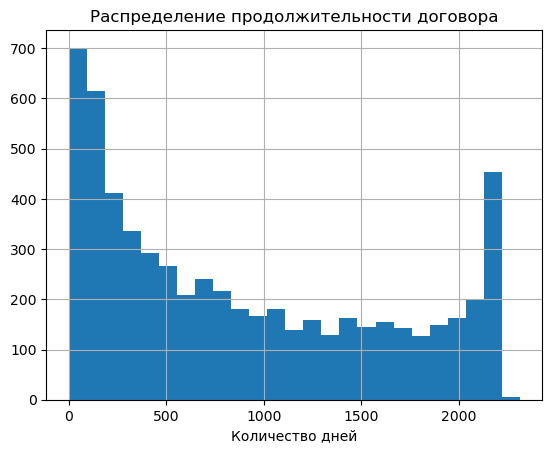

In [27]:
df.query('activity == 0')['duration'].hist(bins=25)
plt.title('Распределение продолжительности договора')
plt.xlabel('Количество дней') 

Text(0.5, 0, 'Количество дней')

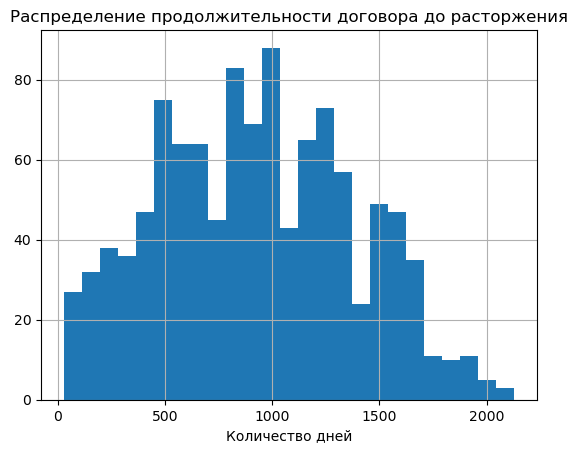

In [28]:
df.query('activity == 1')['duration'].hist(bins=25)
plt.title('Распределение продолжительности договора до расторжения')
plt.xlabel('Количество дней') 

Среди действующих договоров много имеют длительность до года, также видим увеличенние числа договоров со сроком около 2200 дней.Наиболее частая продолжительность расторгнутых договоров от 500 до 1400 дней. 

Рассмотрим ежемесячные расходы

Text(0.5, 0, 'Величина расходов')

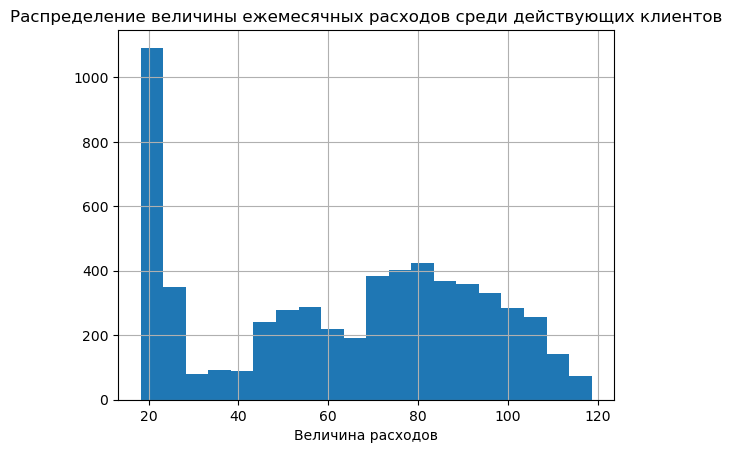

In [29]:
df.query('activity == 0')['monthly_charges'].hist(bins=20)
plt.title('Распределение величины ежемесячных расходов среди действующих клиентов')
plt.xlabel('Величина расходов') 

Text(0.5, 0, 'Величина расходов')

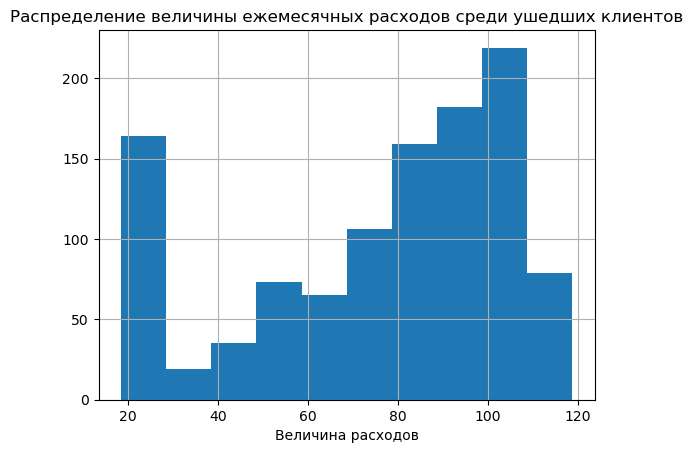

In [30]:
df.query('activity == 1')['monthly_charges'].hist(bins=10)
plt.title('Распределение величины ежемесячных расходов среди ушедших клиентов')
plt.xlabel('Величина расходов') 

У действующих клиентов пик ежемесячеых расходов находится в районе 20  у.е., еще один  пик в районе 80 уе. У ушедших  пик в районе 100 у.е. и небольшое возвышение в районе 20 у.е. Такое распределение говорит о том, ушедшие клиенты были в  большей степени недовольны ценой на услуги. 

## Разделение на выборки

In [31]:
# Выднлим числовые и категориальные признаки
num_cols = ['monthly_charges','duration']
cat_cols = [
    'type',               
    'paperless_billing', 
    'payment_method',
    'senior_citizen',
    'partner',
    'internet_service', 
    'online_security',
    'online_backup',
    'device_protection', 
    'tech_support', 
    'streaming_tv',
    'streaming_movies', 
    'multiple_lines'
]
RS = 17072023

In [32]:
# Разделим выборки
features = df.drop(['activity'], axis=1)
target = df['activity']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RS,stratify=target)

In [33]:
# проверим размеры выборок
display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)


(5282, 15)

(5282,)

(1761, 15)

(1761,)

Выборки разделены корректно


In [34]:
# Масштабируем числовые признаки
pd.options.mode.chained_assignment = None
numeric = num_cols
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric]) 

In [35]:
# закодируем категориальные признаки
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
# обучаем энкодер на заданных категориальных признаках тренировочной выборки
ohe.fit(features_train[cat_cols])
features_train[ohe.get_feature_names_out()] = ohe.transform(features_train[cat_cols])
# удаляем незакодированные изначальные колонки
features_train = features_train.drop(cat_cols, axis=1)

#кодируем тестовую выборку
features_test[ohe.get_feature_names_out()] = ohe.transform(features_test[cat_cols])
features_test = features_test.drop(cat_cols, axis=1)


In [36]:
display(features_train.head(5))
display(features_test.head(5))

,monthly_charges,duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,senior_citizen_1,partner_Yes,internet_service_Fiber optic,internet_service_not_used,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes,multiple_lines_not_used
customerID,,,,,,,,,,,,,,,,,,,,
3503-TYDAY,0.519440,0.597376,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3422-LYEPQ,0.204801,-1.136987,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9801-NOSHQ,-1.499911,-0.290992,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6250-CGGUN,0.650956,1.086855,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3351-NQLDI,0.982243,-0.470711,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


,monthly_charges,duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,senior_citizen_1,partner_Yes,internet_service_Fiber optic,internet_service_not_used,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes,multiple_lines_not_used
customerID,,,,,,,,,,,,,,,,,,,,
9298-WGMRW,1.686435,1.481360,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6366-XIVKZ,-0.056566,-0.738098,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3623-FQBOX,-1.494917,-0.380121,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7054-LGEQW,-0.629243,-1.093153,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7359-WWYJV,1.651476,1.884632,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Признаки закодировались корректно

## Обучение моделей и тестирование лучшей

Выборки к обучению подготовили. Постром Dummy модель для оценки адекватности результатов
моделирования

In [37]:
# Строим DummyClassifier и обучаем
model_dummy = DummyClassifier()
model_dummy.fit(features_train, target_train)
# Делаем предсказание
predicted_D = model_dummy.predict(features_test)
D_proba = model_dummy.predict_proba(features_test)
# рассчитываем метрики
auc_roc_D = roc_auc_score(target_test, D_proba[:,1])
accuracy_D = accuracy_score(target_test, predicted_D)
print('AUC-ROC Dummy модель:' , auc_roc_D, 'Accuracy Dummy модель:', accuracy_D)

AUC-ROC Dummy модель: 0.5 Accuracy Dummy модель: 0.8438387279954571


Метрики модели: AUC-ROC = 0.5 Accuracy = 0.8438387279954571

In [38]:
# Строим LogisticRegression и обучаем
params_lr = {}
model_lr = RandomizedSearchCV(LogisticRegression(random_state=RS,
                        class_weight = 'balanced'), params_lr, scoring= 'roc_auc', n_jobs=-1, random_state=RS, cv=3, verbose=10)

model_lr.fit(features_train, target_train)
# Выводим лучший результат и гиперпараметры
display(model_lr.best_params_)
auc_roc_lr = model_lr.best_score_
display(auc_roc_lr)
print('AUC-ROC LogisticRegression:', auc_roc_lr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{}

0.7575285550787271

AUC-ROC LogisticRegression: 0.7575285550787271


AUC-ROC логистической регресии = 0,76


In [39]:
# Строим RandomForestClassifier
params_rfc = {
    'n_estimators':[i for i in range(10, 100)],
    'max_depth': [None] + [i for i in range(2, 11)]
}
model_rfc = RandomizedSearchCV(RandomForestClassifier(random_state=RS, class_weight = 'balanced'), params_rfc, n_iter=10,
                                       random_state=RS, scoring = 'roc_auc', n_jobs=-1, cv=3, verbose=10)


# Обучаем RandomForestClassifier
model_rfc.fit(features_train, target_train)
# Выводим лучший результат и гиперпараметры
display(model_rfc.best_params_)
auc_roc_rfc = model_rfc.best_score_
print('AUC-ROC RandomForest:', auc_roc_rfc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'n_estimators': 31, 'max_depth': 7}

AUC-ROC RandomForest: 0.8227865590437845


Случайный лес показал рещультат лучше предыдущей модели. AUC-ROC = 0,82 при параметрах n_estimators = 31, max_depth = 7

In [40]:
# Строим и обучаем CatBoostClassifier
params_cbc = {
    'learning_rate': [0.01, 0.1],
    'depth': [None] + [i for i in range(2, 12)],
    'n_estimators': [i for i in range(50, 200)]
}
model_cbc = RandomizedSearchCV(CatBoostClassifier(random_state=RS), params_cbc, n_iter=10, scoring = 'roc_auc', random_state=RS, n_jobs=-1, cv=3, verbose=10)

model_cbc.fit(features_train.values, target_train.values)
# Выводим лучший результат и гиперпараметры
display(model_cbc.best_params_)
auc_roc_traincbc = model_cbc.best_score_
print('AUC-ROC CatBoost:', auc_roc_traincbc)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 0.6147931	total: 144ms	remaining: 25.8s
1:	learn: 0.5685584	total: 147ms	remaining: 13.1s
2:	learn: 0.5247232	total: 152ms	remaining: 8.94s
3:	learn: 0.4825159	total: 156ms	remaining: 6.85s
4:	learn: 0.4471500	total: 160ms	remaining: 5.61s
5:	learn: 0.4266692	total: 165ms	remaining: 4.78s
6:	learn: 0.4062924	total: 169ms	remaining: 4.18s
7:	learn: 0.3939838	total: 173ms	remaining: 3.73s
8:	learn: 0.3823146	total: 178ms	remaining: 3.38s
9:	learn: 0.3694985	total: 182ms	remaining: 3.1s
10:	learn: 0.3598665	total: 186ms	remaining: 2.86s
11:	learn: 0.3542298	total: 190ms	remaining: 2.67s
12:	learn: 0.3491335	total: 194ms	remaining: 2.5s
13:	learn: 0.3447214	total: 198ms	remaining: 2.35s
14:	learn: 0.3392973	total: 202ms	remaining: 2.22s
15:	learn: 0.3361887	total: 206ms	remaining: 2.12s
16:	learn: 0.3330666	total: 210ms	remaining: 2.02s
17:	learn: 0.3305991	total: 214ms	remaining: 1.93s
18:	learn: 0.3288506	total: 218ms

{'n_estimators': 180, 'learning_rate': 0.1, 'depth': 5}

AUC-ROC CatBoost: 0.8767411714847032


Катбуст показал показал результат: AUC-ROC = 0,877 при параметрах n_estimators = 180, max_depth = 5, learning_rate = 0.1

ВЫВОД: Модели LogisticRegression и  RandomForest не показали нужного результата. Модель CatBoostClassifier показала результат AUC-ROC = 0,877, что проходит планку 0,85. Все представленные модели адекватные, их показатели лучше Dummy модели.

### Тестируем лучшую модель 

In [41]:
cbc = CatBoostClassifier(random_state=RS, n_estimators = 180, learning_rate = 0.1, depth = 5)
cbc.fit(features_train.values, target_train.values)
predicted_cbc = cbc.predict(features_test.values)
cbc_proba = cbc.predict_proba(features_test.values)
auc_roc_cbc = roc_auc_score(target_test.values, cbc_proba[:,1])
accuracy_cbc = accuracy_score(target_test.values, predicted_cbc)
print('AUC-ROC CatBoost:' , auc_roc_cbc, 'Accuracy CatBoost:', accuracy_cbc)

0:	learn: 0.6147931	total: 5.05ms	remaining: 904ms
1:	learn: 0.5685584	total: 8.71ms	remaining: 775ms
2:	learn: 0.5247232	total: 13.9ms	remaining: 822ms
3:	learn: 0.4825159	total: 19.2ms	remaining: 844ms
4:	learn: 0.4471500	total: 24.3ms	remaining: 851ms
5:	learn: 0.4266692	total: 29.9ms	remaining: 868ms
6:	learn: 0.4062924	total: 35.4ms	remaining: 875ms
7:	learn: 0.3939838	total: 40.7ms	remaining: 875ms
8:	learn: 0.3823146	total: 45.9ms	remaining: 872ms
9:	learn: 0.3694985	total: 51.9ms	remaining: 882ms
10:	learn: 0.3598665	total: 57.2ms	remaining: 879ms
11:	learn: 0.3542298	total: 62.5ms	remaining: 875ms
12:	learn: 0.3491335	total: 67ms	remaining: 861ms
13:	learn: 0.3447214	total: 72.2ms	remaining: 856ms
14:	learn: 0.3392973	total: 77.3ms	remaining: 850ms
15:	learn: 0.3361887	total: 84.4ms	remaining: 865ms
16:	learn: 0.3330666	total: 89.8ms	remaining: 861ms
17:	learn: 0.3305991	total: 94.5ms	remaining: 851ms
18:	learn: 0.3288506	total: 99.6ms	remaining: 844ms
19:	learn: 0.3273024	tot

На тесте модель показала хороший результат. AUC-ROC= 0.87, Accuracy = 0.88.

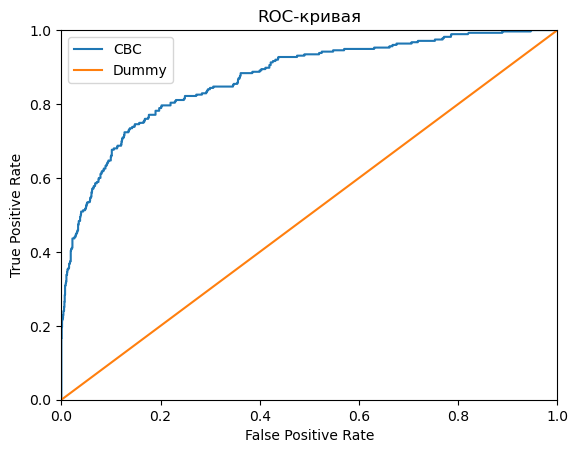

In [42]:
# ROC-кривая лучшей модели 
cbc_fpr, cbc_tpr, cbc_thresholds = roc_curve(target_test, cbc_proba[:,1])
plt.plot(cbc_fpr, cbc_tpr, label="CBC")
# ROC-кривая Dummy модели 
D_fpr, D_tpr, D_thresholds = roc_curve(target_test, D_proba[:,1])
plt.plot(D_fpr, D_tpr, label="Dummy")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(fontsize=10)
plt.show()

Вывод: на тренировачной выборке AUC-ROC = 0,877, на тестовой AUC-ROC= 0.87. Это говорит о том, что модель не склонна к переобучению или недообучению. Модель адекватная.

## Общий вывод

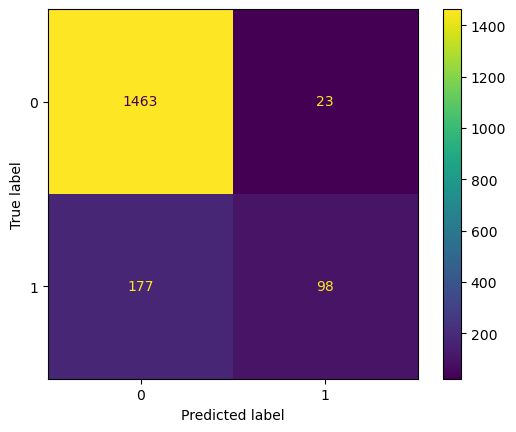

In [43]:
#Построим матрицу ошибок для выбранной модели
matrix = confusion_matrix(target_test, predicted_cbc)
ConfusionMatrixDisplay(matrix).plot()

Модель сделала 177 ложно-негативных предсказаний и 23 ложно-положительных.  Правильных позитивных предсказаний факта ухода клиента модель сделала 98. Модель смогла правильно предсказать только 36% случаев ухода клиента.

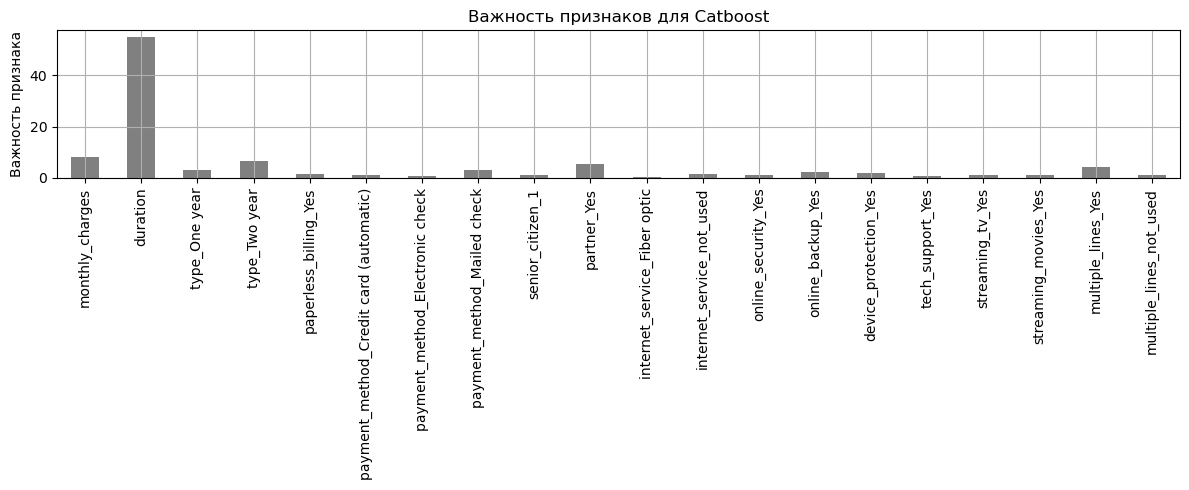

In [44]:
#Проведем анализ важности признаков для модели
feature_importance_cb = cbc.get_feature_importance()
feature_importance_cb = pd.Series(feature_importance_cb, index=features_test.columns)

plt.show()
fig, ax = plt.subplots(figsize=(12,5))
feature_importance_cb.plot.bar(ax=ax, color='grey', grid=True)
ax.set_title("Важность признаков для Catboost")
ax.set_ylabel('Важность признака')
fig.tight_layout()

Наиболее значимыми для модели стали прзнаки duration, monthly_charges, type, partner, multiple_lines

#### Вывод:

In [45]:
table = pd.DataFrame({'Модель': ['DummyClassifier','LogisticRegression',  'RandomForestClassifier', 'CatBoostClassifier'], 
                      'AUC-ROC на обучающей выборке': ['-', auc_roc_lr, auc_roc_rfc, auc_roc_traincbc], 
                      'AUC-ROC на тестовой выборке': [auc_roc_D, '-','-', auc_roc_cbc], 
                      'Accuracy': [accuracy_D, '-', '-', accuracy_cbc] 
                     })
                     
table

,Модель,AUC-ROC на обучающей выборке,AUC-ROC на тестовой выборке,Accuracy
0,DummyClassifier,-,0.5,0.843839
1,LogisticRegression,0.757529,-,-
2,RandomForestClassifier,0.822787,-,-
3,CatBoostClassifier,0.876741,0.869902,0.886428


В ходе работы мы корректно загрузили датасеты и успешно ознакомились с данными. После объединения заполнили появившиеся пропуски, изменили типы данных, где необходимо, создали новый признак, выделили целевой в новом столбце. 
После проверки признаков на корреляцию и рассмотрения графиков приняли решения по удалению лишних столбцов.

При изучении датасета выяснии ,что среди действующих договоров много имеют длительность до года(новые клиенты), также видим увеличенние числа договоров со сроком около 2200 дней. Наиболее частая продолжительность расторгнутых договоров от 500 до 1400 дней. У действующих клиентов пик ежемесячеых расходов находится в районе 20  у.е., еще один  пик в районе 80 у.е. У ушедших  пик в районе 100 у.е. и небольшое возвышение в районе 20 у.е. Такое распределение говорит о том, что ушедшие клиенты были в  большей степени недовольны ценой на услуги. 
  
По графикам видим дисбаланс классов у целевого признака.Там, где необходимо при обучении, была применена балансировка при помощи параметра class weight. После провели разбиение на выборки. Также проводилии масштабирование числовых признаков и кодировние категориальных.
Далее были подобраны гиперпараметры и обучены такие модели: LogisticRegression, RandomForestClassifier, CatBoostClassifier.
Модели LogisticRegression и  RandomForest не показали нужного результата. Модель CatBoostClassifier показала результат AUC-ROC = 0,877, что проходит планку 0,85. Все представленные модели адекватные, их показатели лучше Dummy модели.

Модель Catboost показала хороший результат на тестовых данных. AUC-ROC : 0.869, Accuracy CatBoost: 0.886.
Модель сделала 177 ложно-негативных предсказаний и 23 ложно-положительных.  Правильных позитивных предсказаний факта ухода клиента модель сделала 98. Модель смогла правильно предсказать только 36% случаев ухода клиента.
Наиболее значимыми для модели стали прзнаки duration, monthly_charges, type, partner, multiple_lines.

В итоге модель можно рассматривать для использования, однако её применение поможет сохранять лишь 36% от надумавших уйти клиентов, если их удовлетворит предложение компании. 

## Отчет о работе


1. Какие пункты плана были выполнены, а какие — нет. Почему?
- Работа была выполнена согласно ранее составленному плану.
2. Какие трудности возникли и как вы их преодолели?
- В данных отсутствовал целлевой признак, однако его легко было выделить ориентируясь на столбец end_date.
- Также из-за особенностей данных в ячейке total_charges не представлялось возможным для изменеия типа использовать привычный способ(astype(int)), но способ to_numeric с указанием агрумента errors ='coerce' сработал.
3. Какие ключевые шаги в решении задачи вы выделили?
- Ключевыми этапами работы отмечу выделение целевого признака,предварительную обработку данных и подбор гиперпараметров.
4. Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?
- 'monthly_charges','duration' - числовые признаки, были масштабированны.
- 'type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'internet_service', 'online_security',   'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines' - категориальные признаки  были закодрованны с помощью OHE.
- Перед эти создали признак duration вычитанием  из конечной даты начальной даты контракта, заполнялись пропуски в столбцах internet_service и multiple_lines значением not_used,   в столбцах online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies - значением No.
- Также перед кодированием разбили данные на выборки используя стратификацию и с соотношением тренировочной выборки к тестовой 75% к 25%.
5. Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?
- CatBoostClassifier стала итоговой моделью при гиперпараметрах n_estimators = 180, max_depth = 5, learning_rate = 0.1,
Random State = 17072023. Данная модель смогла достичь метрики ROC-AUC: 0.87 , Accuracy: 0.88.
- Ниже представлены ROC-кривая, матрица ошибок и график важности признаков для модели.
 


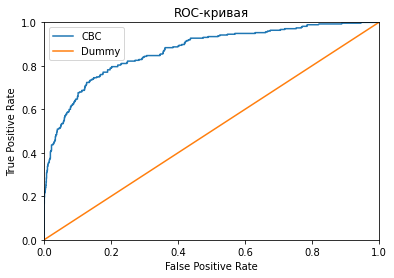
Матрица ошибок
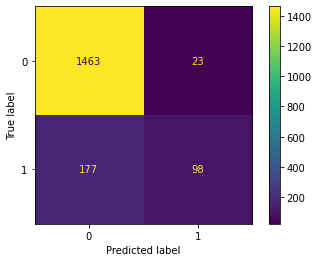
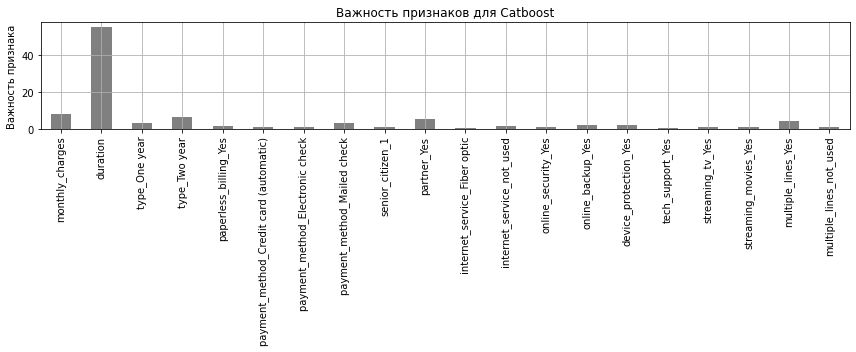